## House sales price prediction

### First of all load and analyze data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import minmax_scale
import os
from keras.layers import Input, Dense
from keras.models import Sequential,Model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [2]:
train=pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Here we are making classes according to quantiles

Making 3 classes according to first, second and third quantile ranges. After that I plotted how many samples has each class. Classes are balanced because they have approximately same number of samples.

In [3]:
train['klasa']=train['SalePrice']
train['klasa'][train['SalePrice']<np.quantile(train['SalePrice'], .33)]=0
train['klasa'][train['SalePrice']>=np.quantile(train['SalePrice'], .33)]=1
train['klasa'][train['SalePrice']>=np.quantile(train['SalePrice'], .67)]=2

print('Class 1',sum(train['klasa']==0),'samples')
print('Class 2',sum(train['klasa']==1),'samples')
print('Class 3',sum(train['klasa']==2),'samples')



Class 1 472 samples
Class 2 505 samples
Class 3 483 samples


<ipython-input-3-f47e712b8048>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['klasa'][train['SalePrice']<np.quantile(train['SalePrice'], .33)]=0
<ipython-input-3-f47e712b8048>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['klasa'][train['SalePrice']>=np.quantile(train['SalePrice'], .33)]=1
<ipython-input-3-f47e712b8048>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['klasa'][train['SalePrice']>=np.quantile(tra

According to loaded data, we can conclude that our dataset has 80 features. Training database has 81 column, because the last column is label for house sales price.

### Feature analysis (numerical and categorical)

First we print all categorical and numerical columns

In [4]:
cols=train.columns
num_cols=train._get_numeric_data().columns
print(num_cols)
cat_cols=train.select_dtypes(include=['category', object]).columns
print(cat_cols)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'klasa'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'He

Then we are reducing features which have a large percent of missing values, in this case I choose if feature has more than 40% missing values, then we delete it. 


In [5]:
percent=train.isnull().sum().sort_values(ascending=False)/len(train)
total=train.isnull().sum().sort_values(ascending=False)
missing=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


In [6]:
train.drop(missing[percent>0.4].index,axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,klasa
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,2
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,2
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,8,2007,WD,Normal,175000,1
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2010,WD,Normal,210000,2
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2500,5,2010,WD,Normal,266500,2
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2010,WD,Normal,142125,1


Categorical missing values are filled with None, numerical values are filled with mean value. 

In [7]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)


In [8]:
cols=train.columns[train.isnull().any()].to_list()
for col in cols:
    train[col].fillna(np.mean(train[col]),inplace=True)


In [9]:
train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
klasa            0
Length: 82, dtype: int64

## Converting categorical featured into numerical
### Label Encoding
Random forest, autoencoders and correlation coeficient are calculated using only numerical values, so we need to convert our categorical features into numerical. They can be converted by OneHotEncoding using padas.get_dummies, but on that way we are making new column for each different value. Instead, I used Label Encoding which adds a number to every category. train2 training set has converted features. The same is for testset.

Converting methods: One Hot Encodding (sa pd.get_dummies), Custom Binary Encoding, Find and Replace.

In [10]:
train2=train.copy()
objekti=train.select_dtypes('object').columns
for i in range(len(objekti)):
    train2[objekti[i]]=train2[objekti[i]].astype('category')
    train2[objekti[i]]=train2[objekti[i]].cat.codes
train2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,klasa
0,1,60,3,65.0,8450,1,1,3,3,0,...,3,4,1,0,2,2008,8,4,208500,2
1,2,20,3,80.0,9600,1,1,3,3,0,...,3,4,1,0,5,2007,8,4,181500,1
2,3,60,3,68.0,11250,1,1,0,3,0,...,3,4,1,0,9,2008,8,4,223500,2
3,4,70,3,60.0,9550,1,1,0,3,0,...,3,4,1,0,2,2006,8,0,140000,1
4,5,60,3,84.0,14260,1,1,0,3,0,...,3,4,1,0,12,2008,8,4,250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,...,3,4,1,0,8,2007,8,4,175000,1
1456,1457,20,3,85.0,13175,1,1,3,3,0,...,3,2,1,0,2,2010,8,4,210000,2
1457,1458,70,3,66.0,9042,1,1,3,3,0,...,3,0,3,2500,5,2010,8,4,266500,2
1458,1459,20,3,68.0,9717,1,1,3,3,0,...,3,4,1,0,4,2010,8,4,142125,1


## Dimension reduction methods
Random Forest, Autoencoder and Feature Correlation.


In [11]:
y=train['SalePrice'].to_numpy()
y_klas=train['klasa'].to_numpy()
train2=train2.drop(columns=['SalePrice','klasa'])

### 1. Random Forest

Random forest regresor is trained and used for feature selection (we are choosing n first most important features). According to the graphic, in this case I choose to keep 9 most important features.


In [12]:
def rf(train2,y,max_depth=10,br=-9):
    model = RandomForestRegressor(max_depth,random_state=1)
    model.fit(train2,y)
    features=train2.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:]  # top 10 features
    importances[indices]
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    indices=indices[br:]
    indices
    features_rf=[features[i] for i in indices]
    train_rf=train2[features_rf]
    return features_rf,train_rf

### 2. Autoencoders

Autoencoder can also be used for dimension reduction. They contain encoder and decoder. Autoencoders learn to choose which features are important. They are used as dimension reduction and noise rejection technique.


In [13]:
def encoder(train2,encoding_dim):
    #skaliranje za neuralnu mrezu
    train_scaled = minmax_scale(train2, axis = 0)
    ncol = train_scaled.shape[1]
    input_dim = Input(shape = (ncol, ))
    # Define encoding layer
    encoded = Dense(encoding_dim, activation='elu')(input_dim)
    encoder = Model(inputs = input_dim, outputs = encoded)
    encoded_input = Input(shape = (encoding_dim, ))
    encoded_train = pd.DataFrame(encoder.predict(train_scaled))
    return encoded_train

### 3. Reducing features with higher correlation

First we are drawing correlation matrix with only numeric values. After that I formed high triangle matrix from correlation matrix and reduced features which correlation coeficient with other features is higher than 0.4.


In [14]:
cor = train2.corr()

# Select upper triangle of correlation matrix
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
train_corr=train2.copy()
train_corr.drop(train_corr[to_drop],axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,0,3,4,1,0,2,2008,8,4
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,0,3,4,1,0,5,2007,8,4
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,0,3,4,1,0,9,2008,8,4
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,0,3,4,1,0,2,2006,8,0
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,...,0,0,3,4,1,0,8,2007,8,4
1456,1457,20,3,85.0,13175,1,1,3,3,0,...,0,0,3,2,1,0,2,2010,8,4
1457,1458,70,3,66.0,9042,1,1,3,3,0,...,0,0,3,0,3,2500,5,2010,8,4
1458,1459,20,3,68.0,9717,1,1,3,3,0,...,0,0,3,4,1,0,4,2010,8,4


## Regression on dataset with reduced features

Instead directly classification, we are first calculating house sales price and then converting it to class is the price high, low or medium and compare it to the label in training set.


### Random forest regressor with original features

Feature selection with 3 dmension reduction methods. Forming different variables which cintain 3 different feature sets.

Splitting dataset to training and test with 80:20.


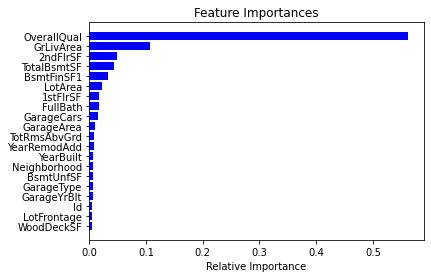

In [15]:
features_rf,train_rf=rf(train2,y,br=-14)
train_encoded=encoder(train2,encoding_dim=30)
cor = train2.corr()

# Select upper triangle of correlation matrix
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
train_corr=train2.copy()
train_corr.drop(train_corr[to_drop],axis=1)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(train_rf,y,test_size=0.2)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_encoded,y,test_size=0.2)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(train_corr,y,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(train2,y,test_size=0.2)

y_test[y_test<np.quantile(train['SalePrice'], .33)]=0
y_test[(y_test>=np.quantile(train['SalePrice'], .33)) & (y_test<np.quantile(train['SalePrice'], .67))]=1
y_test[y_test>=np.quantile(train['SalePrice'], .67)]=2

y_test_rf[y_test_rf<np.quantile(train['SalePrice'], .33)]=0
y_test_rf[(y_test_rf>=np.quantile(train['SalePrice'], .33)) & (y_test_rf<np.quantile(train['SalePrice'], .67))]=1
y_test_rf[y_test_rf>=np.quantile(train['SalePrice'], .67)]=2

y_test_enc[y_test_enc<np.quantile(train['SalePrice'], .33)]=0
y_test_enc[(y_test_enc>=np.quantile(train['SalePrice'], .33)) & (y_test_enc<np.quantile(train['SalePrice'], .67))]=1
y_test_enc[y_test_enc>=np.quantile(train['SalePrice'], .67)]=2

y_test_cor[y_test_cor<np.quantile(train['SalePrice'], .33)]=0
y_test_cor[(y_test_cor>=np.quantile(train['SalePrice'], .33)) & (y_test_cor<np.quantile(train['SalePrice'], .67))]=1
y_test_cor[y_test_cor>=np.quantile(train['SalePrice'], .67)]=2


In [16]:
print('Random forest features',features_rf)
print('Correlation features',train_corr.columns)


Random forest features ['Neighborhood', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'FullBath', '1stFlrSF', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'OverallQual']
Correlation features Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', '

#### 1.Random forest reduction test

In [17]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5],'n_jobs' :[-1] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_rf, y_train_rf)
best_params = grid_rf.best_params_
print(best_params)
print(np.sqrt(-grid_rf.best_score_))
rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV

rfr.fit(X_train_rf,y_train_rf)
y_pred=rfr.predict(X_test_rf)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_rf)/len(y_test_rf)
regresija_obicno=dict([('RandomForest',tacn)])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   20.4s finished


{'min_samples_split': 4, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 5}
29084.092478375675


#### 2.Autoencoder reducted features test

In [18]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_enc, y_train_enc)
best_params = grid_rf.best_params_
print(best_params)
print(np.sqrt(-grid_rf.best_score_))
rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train_enc,y_train_enc)
y_pred=rfr.predict(X_test_enc)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_enc)/len(y_test_enc)
regresija_obicno.update([('Autoenkoder',tacn)])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.2min finished


{'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
48161.406289189676


#### 3. Correlation reducted features test

In [19]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] , 'max_depth':[4,10,20,30]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_cor, y_train_cor)
best_params = grid_rf.best_params_
print(best_params)
print(np.sqrt(-grid_rf.best_score_))

rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train_cor,y_train_cor)
y_pred=rfr.predict(X_test_cor)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_cor)/len(y_test_cor)
regresija_obicno.update([('Korelacija',tacn)])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.5min finished


{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 70, 'random_state': 5}
36215.22116950058


#### 4. Test on original features

In [20]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] , 'max_depth':[4,10,20,30]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train, y_train)
best_params = grid_rf.best_params_
print(best_params)
print(np.sqrt(-grid_rf.best_score_))

rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test)/len(y_test)
regresija_obicno.update([('Bez redukcije dimenzija',tacn)])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.1min finished


{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
31417.31570271853


# Log transform to all numerical values

In [21]:
num_cols=num_cols.drop(['klasa','SalePrice'])
train3=train2.copy()
for col in num_cols:
    if(train3[col].all()!=0):
        train3[col]=np.log(train3[col])


#### Reducing features with different techniques

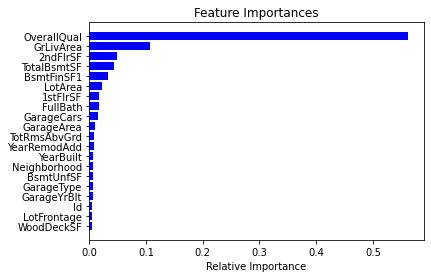

In [22]:
features_rf,train_rf=rf(train3,y,br=-14)
encoding_dim=20
train_encoded=encoder(train3,encoding_dim)
cor = train3.corr()

# Select upper triangle of correlation matrix
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
train_corr=train3.copy()
train_corr.drop(train_corr[to_drop],axis=1)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(train_rf,y,test_size=0.2)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_encoded,y,test_size=0.2)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(train_corr,y,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(train3,y,test_size=0.2)

y_test[y_test<np.quantile(train['SalePrice'], .33)]=0
y_test[(y_test>=np.quantile(train['SalePrice'], .33)) & (y_test<np.quantile(train['SalePrice'], .67))]=1
y_test[y_test>=np.quantile(train['SalePrice'], .67)]=2

y_test_rf[y_test_rf<np.quantile(train['SalePrice'], .33)]=0
y_test_rf[(y_test_rf>=np.quantile(train['SalePrice'], .33)) & (y_test_rf<np.quantile(train['SalePrice'], .67))]=1
y_test_rf[y_test_rf>=np.quantile(train['SalePrice'], .67)]=2

y_test_enc[y_test_enc<np.quantile(train['SalePrice'], .33)]=0
y_test_enc[(y_test_enc>=np.quantile(train['SalePrice'], .33)) & (y_test_enc<np.quantile(train['SalePrice'], .67))]=1
y_test_enc[y_test_enc>=np.quantile(train['SalePrice'], .67)]=2

y_test_cor[y_test_cor<np.quantile(train['SalePrice'], .33)]=0
y_test_cor[(y_test_cor>=np.quantile(train['SalePrice'], .33)) & (y_test_cor<np.quantile(train['SalePrice'], .67))]=1
y_test_cor[y_test_cor>=np.quantile(train['SalePrice'], .67)]=2

#### 1. Random Forest reduction

In [23]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5],'n_jobs' :[-1] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_rf, y_train_rf)
best_params = grid_rf.best_params_
rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train_rf, y_train_rf)
print(best_params)
print('score',np.sqrt(-grid_rf.best_score_))
y_pred=rfr.predict(X_test_rf)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_rf)/len(y_test_rf)
print('accuracy',tacn)
regresija_log=dict([('Random Forest',tacn)])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   18.6s finished


{'min_samples_split': 6, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 5}
score 30266.01375479074
accuracy 0.8424657534246576


#### 2. Autoencoder reduction

In [24]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_enc, y_train_enc)
best_params = grid_rf.best_params_
print(best_params)
print('score',np.sqrt(-grid_rf.best_score_))
rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train_enc, y_train_enc)
y_pred=rfr.predict(X_test_enc)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_enc)/len(y_test_enc)
print('accuracy',tacn)
regresija_log.update([('Autoenkoder',tacn)])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   51.7s finished


{'min_samples_split': 6, 'n_estimators': 100, 'random_state': 5}
score 47197.499837221505
accuracy 0.6575342465753424


#### 3. Crosscorrelation reduction

In [25]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] , 'max_depth':[4,10,20,30]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train_cor, y_train_cor)
best_params = grid_rf.best_params_
print(best_params)
print('score',np.sqrt(-grid_rf.best_score_))

rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train_cor, y_train_cor)
y_pred=rfr.predict(X_test_cor)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test_cor)/len(y_test_cor)
print('accuracy',tacn)
regresija_log.update([('Korelacija',tacn)])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.0min finished


{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
score 30865.58988319465
accuracy 0.8664383561643836


#### Without dimension reduction

In [26]:
score_calc = 'neg_mean_squared_error'
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] , 'max_depth':[4,10,20,30]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train, y_train)
best_params = grid_rf.best_params_
print(best_params)
print('score',np.sqrt(-grid_rf.best_score_))

rfr = RandomForestRegressor(min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],random_state=5, verbose=False)# Perform K-Fold CV
rfr.fit(X_train, y_train)
y_pred=rfr.predict(X_test)
y_pred[y_pred<np.quantile(train['SalePrice'], .33)]=0
y_pred[(y_pred>=np.quantile(train['SalePrice'], .33)) & (y_pred<np.quantile(train['SalePrice'], .67))]=1
y_pred[y_pred>=np.quantile(train['SalePrice'], .67)]=2
tacn=np.sum(y_pred==y_test)/len(y_test)
print('accuracy',tacn)
regresija_log.update([('Bez redukcije dimenzija',tacn)])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.9min finished


{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 70, 'random_state': 5}
score 31009.094062371878
accuracy 0.839041095890411


# Classification

As classification technique, we are using Naive Bayes. We have 3 classes: high, low and medium, which are divided equally according to quantiles. Variable y_klas has 0, 1 i 2 values for classes. 

## Without log scale

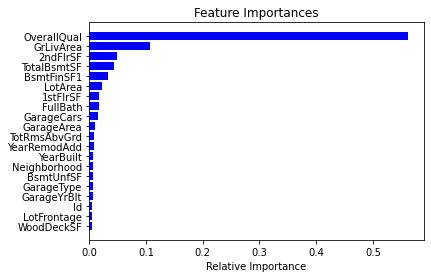

In [27]:
features_rf,train_rf=rf(train2,y,br=-14)
train_encoded=encoder(train2,encoding_dim)
cor = train2.corr()

# Select upper triangle of correlation matrix
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
train_corr=train2.copy()
train_corr.drop(train_corr[to_drop],axis=1)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(train_rf,y_klas,test_size=0.2)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_encoded,y_klas,test_size=0.2)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(train_corr,y_klas,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(train2,y_klas,test_size=0.2)

#### 1. Random Forest reduction

In [28]:
gnb = GaussianNB()
gnb.fit(X_train_rf, y_train_rf)
pred=gnb.predict(X_test_rf)
tacn_rf=np.sum(pred==y_test_rf)/len(y_test_rf)
print('accuracy',tacn_rf)

nbc_obicno=dict([('Random Forest',tacn_rf)])

accuracy 0.8287671232876712


#### 2. Autoencoder reduction

In [29]:
gnb = GaussianNB()
gnb.fit(X_train_enc, y_train_enc)
pred=gnb.predict(X_test_enc)
rez_encoder=np.sum(pred==y_test_enc)/len(y_test_enc)
print('accuracy',rez_encoder)
nbc_obicno.update([('Autoencoder',rez_encoder)])


accuracy 0.6712328767123288


#### 3. Correlation reduction

In [30]:
gnb = GaussianNB()
gnb.fit(X_train_cor, y_train_cor)
pred=gnb.predict(X_test_cor)
tacn_corr=np.sum(pred==y_test_cor)/len(y_test_cor)
print('accuracy',tacn_corr)
nbc_obicno.update([('Correlation',tacn_corr)])

accuracy 0.726027397260274


#### 4. Without reduction

In [31]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred=gnb.predict(X_test)
tacn=np.sum(pred==y_test)/len(y_test)
print('accuracy',tacn)
nbc_obicno.update([('Without dimension reduction',tacn)])

accuracy 0.7705479452054794


## With log transform

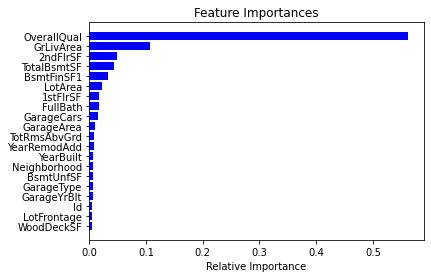

In [32]:
features_rf,train_rf=rf(train3,y,br=-14)
train_encoded=encoder(train3,encoding_dim)
cor = train3.corr()

# Select upper triangle of correlation matrix
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
train_corr=train3.copy()
train_corr.drop(train_corr[to_drop],axis=1)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(train_rf,y_klas,test_size=0.2)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_encoded,y_klas,test_size=0.2)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(train_corr,y_klas,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(train3,y_klas,test_size=0.2)


#### 1. Random Forest 
Reducted table

In [33]:
X_train_rf

,Neighborhood,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageArea,GarageCars,FullBath,1stFlrSF,LotArea,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
1081,19,7.582229,7.582229,1.609438,308,1,1,6.946976,8.922658,824,1040,0,6.946976,1.609438
80,12,7.584773,7.584773,2.079442,509,1,2,7.074963,9.472705,448,896,960,7.669495,1.791759
991,17,7.540090,7.593878,2.079442,424,2,1,6.820016,9.779680,216,916,826,7.462789,2.079442
291,18,7.555905,7.600902,2.197225,0,0,2,6.841615,8.645938,210,780,780,7.447751,1.609438
1094,12,7.578657,7.600902,1.386294,308,1,1,6.841615,8.677269,248,936,0,6.841615,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,14,7.586296,7.586296,1.945910,487,2,2,7.302496,9.412710,998,1484,0,7.302496,1.609438
1210,20,7.596894,7.596894,2.079442,462,2,2,6.961296,9.325275,0,1055,790,7.520235,1.791759
527,16,7.604894,7.604894,2.397895,858,3,2,7.297091,9.612333,1330,1452,1237,7.905810,2.197225
1401,8,7.602900,7.602900,2.079442,398,2,2,6.761573,8.911260,759,839,729,7.373374,1.791759


In [34]:
gnb = GaussianNB()
gnb.fit(X_train_rf, y_train_rf)
pred=gnb.predict(X_test_rf)
tacn_rf=np.sum(pred==y_test_rf)/len(y_test_rf)
print('accuracy',tacn_rf)
nbc_log=dict([('Random Forest',tacn_rf)])

accuracy 0.8082191780821918


#### 2. Autoencoder reduction

In [35]:
X_train_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
662,0.513768,-0.119783,0.878250,0.598585,0.934333,-0.114890,-0.061847,0.347956,0.094481,-0.898790,-0.196111,-0.553070,0.275786,-0.228234,-0.241435,0.389144,-0.559534,0.730615,0.736997,-0.088713
926,-0.183647,0.738054,0.589150,0.137391,1.677083,-0.383834,-0.529628,0.423370,-0.609157,-0.863511,-0.335133,-0.253147,0.214214,-0.263598,0.602163,0.239021,-0.338192,1.193290,0.417427,-0.375169
1145,-0.133191,0.039186,1.239209,0.434680,1.510319,-0.330569,-0.366235,0.350741,-0.216430,-0.760884,-0.496707,-0.164096,0.316519,-0.251327,0.652559,0.315099,-0.455655,1.019984,0.290880,-0.191417
250,-0.209893,0.419786,1.704399,0.732600,0.810230,0.126963,-0.101128,0.450542,0.041616,-0.859687,-0.365901,-0.107750,0.059196,0.298583,0.382142,0.407213,-0.550099,0.682157,0.122479,-0.245168
878,0.281651,0.713515,1.008232,0.782880,0.872714,0.084938,-0.064734,0.272448,-0.136293,-0.875162,-0.523282,-0.063800,-0.180183,-0.218587,0.055530,0.268541,-0.099434,0.979419,0.063222,0.033279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,-0.132862,0.093015,0.665749,0.331215,1.127090,-0.066753,-0.088019,0.217446,-0.137588,-0.730684,-0.548194,-0.109533,-0.149300,-0.281869,0.306714,-0.213116,-0.620677,0.784538,0.668680,0.096462
1220,-0.030043,0.313829,1.148769,0.422302,1.187231,-0.112745,-0.220189,-0.064290,0.162586,-0.809302,-0.301707,-0.237662,0.059000,-0.023489,0.537432,0.411226,-0.381193,0.591561,0.322134,-0.126859
871,0.230236,0.618834,0.862364,0.328331,1.507160,0.101029,-0.254181,0.206101,-0.234536,-0.868045,-0.441025,-0.295929,-0.095478,-0.140096,0.351250,0.345782,-0.231454,0.815717,0.444063,-0.463287
104,0.418841,0.269930,1.457586,0.216268,1.374973,-0.389810,-0.142248,0.248443,-0.106946,-0.804179,-0.551972,-0.366360,0.668966,-0.297902,0.594468,0.629821,-0.307405,0.340023,0.431941,-0.296943


In [36]:
gnb = GaussianNB()
gnb.fit(X_train_enc, y_train_enc)
pred=gnb.predict(X_test_enc)
rez_encoder=np.sum(pred==y_test_enc)/len(y_test_enc)
print('accuracy',rez_encoder)
nbc_log.update([('Autoenkoder',rez_encoder)])

accuracy 0.6438356164383562


#### 3. Correlation reduction

In [37]:
X_train_cor

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
796,6.680855,2.995732,3,4.262680,9.011524,1,1,3,3,0,...,0,0,3,2,1,0,1.386294,7.604396,8,4
1341,7.201916,2.995732,3,4.189655,9.524786,1,1,3,3,0,...,0,0,3,4,1,0,1.945910,7.604894,8,4
1165,7.061334,2.995732,3,4.369448,9.163354,1,1,0,3,0,...,0,0,3,4,1,0,2.197225,7.605392,6,5
1243,7.126087,2.995732,3,4.672829,9.538996,1,1,3,3,0,...,0,0,3,4,1,0,2.197225,7.603898,6,5
1120,7.021976,3.401197,4,4.077537,9.019543,1,1,3,0,0,...,0,0,3,2,1,0,1.609438,7.604396,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,5.733341,3.401197,3,4.249209,9.420763,1,1,0,3,0,...,0,0,3,4,1,0,1.098612,7.605392,8,4
993,6.901737,4.094345,3,4.219508,9.087721,1,1,3,3,0,...,0,0,3,4,1,0,2.079442,7.603898,6,5
957,6.864848,2.995732,3,4.248495,8.911934,1,1,3,3,0,...,0,0,3,4,1,0,1.386294,7.604396,8,4
959,6.866933,5.075174,1,3.178054,7.852439,1,1,3,3,0,...,0,0,3,4,1,0,1.609438,7.605890,8,4


In [38]:
gnb = GaussianNB()
gnb.fit(X_train_cor, y_train_cor)
pred=gnb.predict(X_test_cor)
tacn_corr=np.sum(pred==y_test_cor)/len(y_test_cor)
print(tacn_corr)
nbc_log.update([('Korelacija',tacn_corr)])

0.7191780821917808


#### 4. Without reduction

In [39]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred=gnb.predict(X_test)
tacn_corr=np.sum(pred==y_test)/len(y_test)
print('accuracy',tacn_corr)
nbc_log.update([('Bez redukcije dimenzija',tacn_corr)])

accuracy 0.7431506849315068


# Classification results


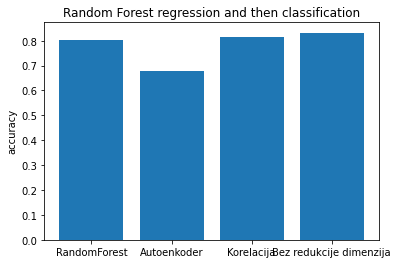

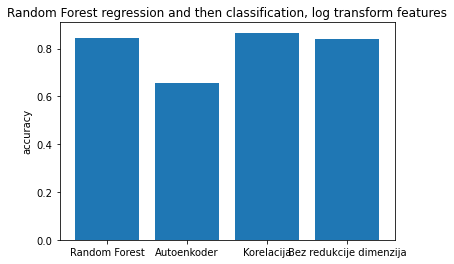

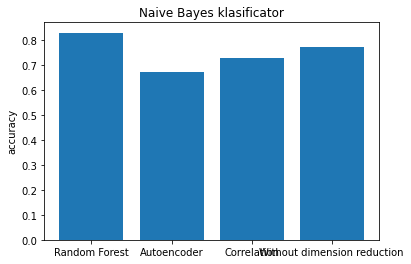

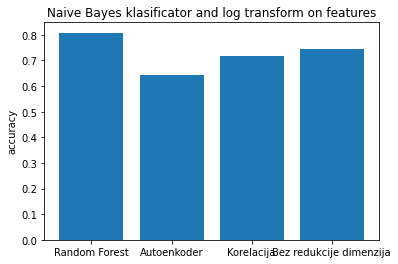

In [40]:
plt.bar(range(len(regresija_obicno)),list(regresija_obicno.values()),align='center')
plt.xticks(range(len(regresija_obicno)),list(regresija_obicno.keys()))
plt.ylabel('accuracy')
plt.title('Random Forest regression and then classification')
plt.show()

plt.bar(range(len(regresija_log)),list(regresija_log.values()),align='center')
plt.xticks(range(len(regresija_log)),list(regresija_log.keys()))
plt.ylabel('accuracy')
plt.title('Random Forest regression and then classification, log transform features')
plt.show()

plt.bar(range(len(nbc_obicno)),list(nbc_obicno.values()),align='center')
plt.xticks(range(len(nbc_obicno)),list(nbc_obicno.keys()))
plt.ylabel('accuracy')
plt.title('Naive Bayes klasificator')
plt.show()

plt.bar(range(len(nbc_log)),list(nbc_log.values()),align='center')
plt.xticks(range(len(nbc_log)),list(nbc_log.keys()))
plt.ylabel('accuracy')
plt.title('Naive Bayes klasificator and log transform on features')
plt.show()

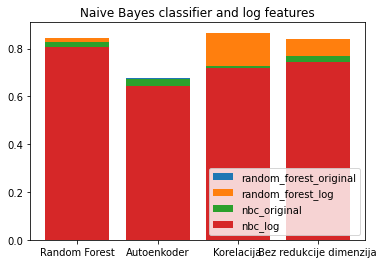

In [42]:
plt.bar(range(len(regresija_obicno)),list(regresija_obicno.values()),align='center')
plt.xticks(range(len(regresija_obicno)),list(regresija_obicno.keys()))
plt.title('Random Forest regression and then classification')


plt.bar(range(len(regresija_log)),list(regresija_log.values()),align='center')
plt.xticks(range(len(regresija_log)),list(regresija_log.keys()))
plt.title('Random Forest regression and then classification, log transform features')

plt.bar(range(len(nbc_obicno)),list(nbc_obicno.values()),align='center')
plt.xticks(range(len(nbc_obicno)),list(nbc_obicno.keys()))
plt.title('Naive Bayes classifier')


plt.bar(range(len(nbc_log)),list(nbc_log.values()),align='center')
plt.xticks(range(len(nbc_log)),list(nbc_log.keys()))
plt.title('Naive Bayes classifier and log features')
plt.legend(['random_forest_original','random_forest_log','nbc_original','nbc_log'],loc='lower right')
plt.show()